## Quantum Teleportation
This algorithm performs the quantum teleportation of a quantum state from one person, Alice, to another, Bob. Here is the general scheme:

1. We start with three qubits:

    * One initialized in the quantum state we want to teleport.

    * Two others prepared in an entangled state shared between Alice and Bob.

2. A CNOT gate is applied between the qubit to be teleported (as control) and Alice's entangled qubit (as target). Then, a Hadamard gate is applied to the qubit we want to teleport.

3. The teleportation is completed by performing measurements on Alice’s two qubits (the one in the initial state and her half of the entangled pair). The result of these measurements is sent to Bob, who applies the appropriate quantum gates to his qubit in order to recover the original state.


![Alt text](quantum_teleportation.png)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# cirq implementation

In [2]:
# insure that cirq is installed in the environment
import cirq

In [3]:
# les qubits
state_to_teleport = cirq.NamedQubit('state_to_teleport')
alice = cirq.NamedQubit('Alice')
bob = cirq.NamedQubit('Bob')


In [ ]:
# I create the state that i want to teleport
message = cirq.Circuit(
    cirq.X(state_to_teleport) ** 1,
    cirq.Y(state_to_teleport) ** 0.5, 
)

In [5]:

teleport_circuit= cirq.Circuit(
    # I create the entangled state between Alice and Bob
    cirq.H(alice),
    cirq.CNOT(alice, bob),

    # message circuit
    message,
    
    # teleportation protocol
    cirq.CNOT(state_to_teleport, alice),
    cirq.H(state_to_teleport),
    cirq.measure(state_to_teleport ,  key='M_1'),
    cirq.measure(alice , key='M_2'),

    # I apply the correction to Bob's qubit based on the measurement results
    cirq.X(bob).with_classical_controls('M_1'),
    cirq.Z(bob).with_classical_controls('M_2'),
)
print(teleport_circuit)

simulator = cirq.Simulator()
#teleport_state(state)

dm_message = cirq.density_matrix_from_state_vector(
        simulator.simulate(message).final_state_vector , indices=[0]
    )

dm_bob_state = cirq.density_matrix_from_state_vector(
        simulator.simulate(teleport_circuit).final_state_vector, indices=[1]
    )



                                          ┌──┐
Alice: ───────────────H───@───────────X─────M────────────────
                          │           │     ║
Bob: ─────────────────────X───────────┼─────╫────────X───Z───
                                      │     ║        ║   ║
state_to_teleport: ───────────X───Y───@────H╫────M───╫───╫───
                                            ║    ║   ║   ║
M_1: ═══════════════════════════════════════╬════@═══^═══╬═══
                                            ║            ║
M_2: ═══════════════════════════════════════@════════════^═══
                                          └──┘


In [7]:
if not np.allclose(dm_message, dm_bob_state):
        raise ValueError(
            f"Alice's state ({message}) not teleported properly. "
            f"Final density matrix of Bob's subsystem: {dm_bob_state}"
        )
print("State successfully teleported!")

State successfully teleported!


# Pennylane implementation

In [1]:
# Insure that pennylane is installed in the environment
import pennylane as qml

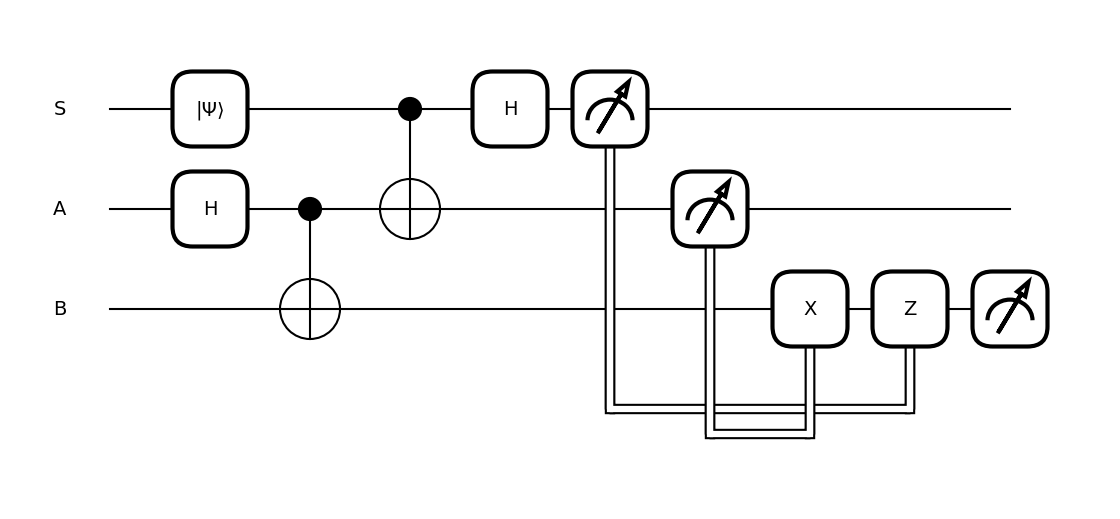

In [4]:
def state_preparation(state):
    qml.StatePrep(state , wires = ["S"])


def entangled_qubit():
    qml.Hadamard(wires = ["A"])
    qml.CNOT(wires = ["A", "B"])

def teleportation_protocol():
    qml.CNOT(wires = ["S", "A"])
    qml.Hadamard(wires = ["S"])

def measure():
    m0 = qml.measure("S")
    m1 = qml.measure("A")
    qml.cond(m1 , qml.PauliX)("B")
    qml.cond(m0 , qml.PauliZ)("B")
   

dev = qml.device("default.qubit", wires=["S", "A", "B"])
@qml.qnode(dev)
def teleportation_circuit(state):
    state_preparation(state)
    entangled_qubit()
    teleportation_protocol()
    measure()
    return qml.density_matrix(wires=["B"])


state = np.array([1/np.sqrt(2) + 0.3j, 0.4 - 0.5j])
_ = qml.draw_mpl(teleportation_circuit  , level = "device")(state)



In [5]:
def teleport_state(state):
    teleported_density_matrix = teleportation_circuit(state)
    original_density_matrix = qml.math.dm_from_state_vector(state)

    if not np.allclose(teleported_density_matrix, original_density_matrix):
        raise ValueError(
            f"Alice's state ({state}) not teleported properly. "
            f"Final density matrix of Bob's subsystem: {teleported_density_matrix}"
        )
    print("State successfully teleported!")


teleport_state(state)

State successfully teleported!


# Qiskit Implementation

In [15]:
# insure that qiskit is installed in the environment
from qiskit import QuantumCircuit, transpile, assemble , QuantumRegister , ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram , array_to_latex

from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate


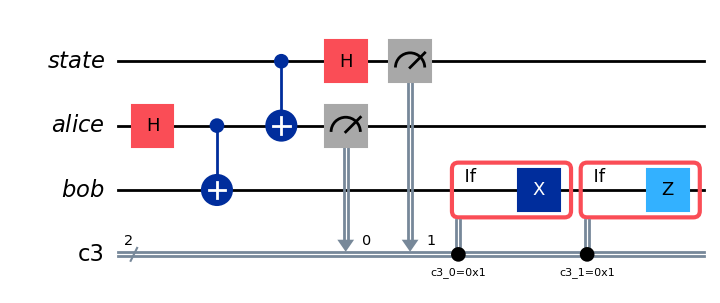

In [16]:
state =  QuantumRegister(size = 1 , name = 'state')
alice = QuantumRegister(size = 1 , name = 'alice')
bob = QuantumRegister(size= 1 , name = 'bob')
m = ClassicalRegister(2)
qc = QuantumCircuit(state, alice, bob , m)

# state to teleport
random_gate = UGate(
    theta = np.random.random()*2*np.pi,
    phi = np.random.random()*2*np.pi,
    lam = np.random.random()*2*np.pi
)


#qc.y(qr[0]) ** 0.5

# entangled state between Alice and Bob
qc.h(alice)
qc.cx(alice, bob)

# teleportation protocol
qc.cx(state, alice)
qc.h(state)


qc.measure(state , m[1])
qc.measure(alice , m[0])
with qc.if_test((m[0] , 1)):
    qc.x(bob[0])



with qc.if_test((m[1] , 1)):
    qc.z(bob[0])
#qc.measure(qr[0], 0)    


qc.draw('mpl')


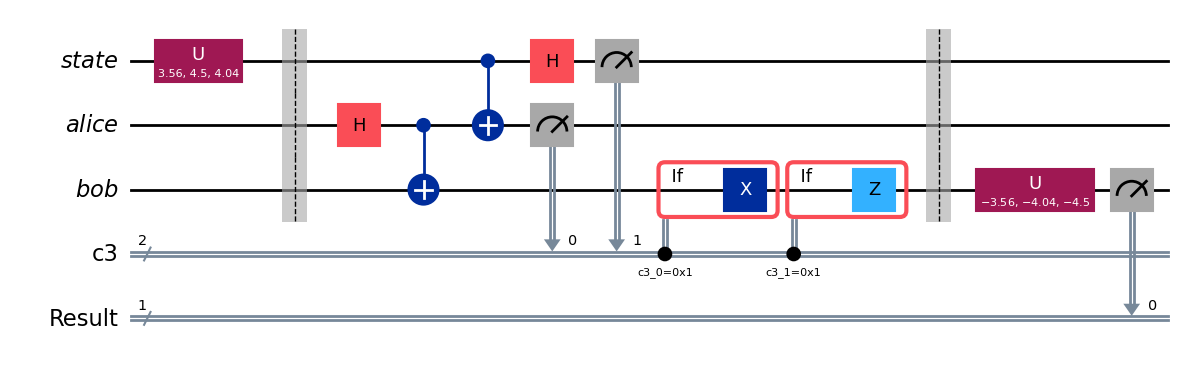

In [17]:
test = QuantumCircuit(state, alice, bob , m)
test.append(random_gate , [state[0]])
test.barrier()
test = test.compose(qc , inplace = False)
test.barrier()

# Finally , apply the inversers of the gates to get the original state
test.append(random_gate.inverse() , [bob[0]])
result = ClassicalRegister(1 , "Result")
test.add_register(result)
test.measure(bob[0] , result[0])

display(test.draw('mpl'))

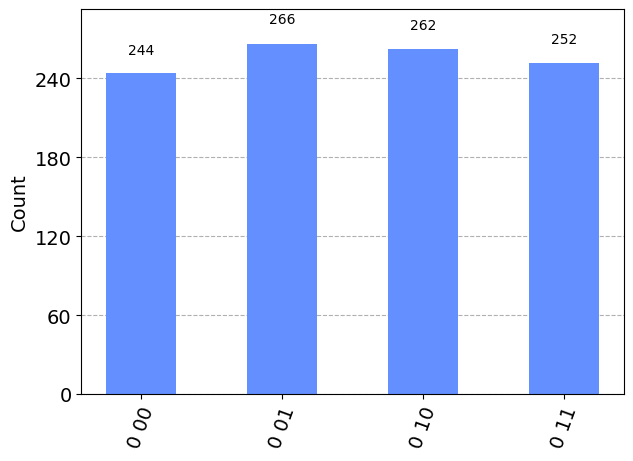

In [18]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

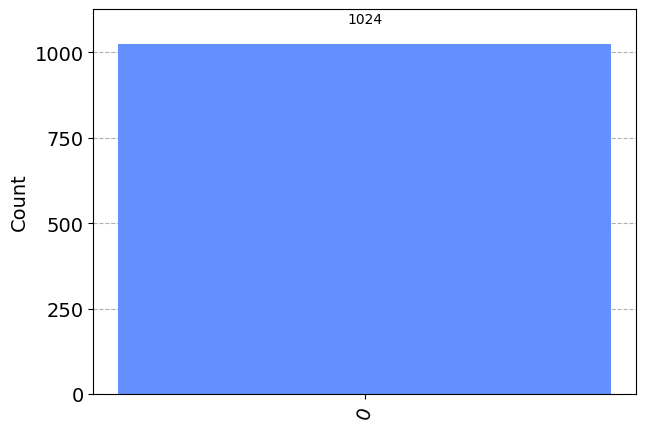

In [19]:
filtered_statistics = marginal_distribution(statistics , [2])
display(plot_histogram(filtered_statistics))